Defining project scope and objectives...
Project timeline created: {'Project Planning': '02-06-2024 to 13-06-2024', 'Preprocessing Approaches': '14-06-2024 to 20-06-2024', 'Model Development': '21-06-2024 to 01-07-2024', 'Model Training and Evaluation': '02-07-2024 to 14-07-2024', 'Comparison and Analysis': '15-07-2024 to 22-07-2024', 'Documentation and Reporting': '23-07-2024 to 04-08-2024', 'Presentation and Review': '04-08-2024 to 15-08-2024'}
Loading dataset...
Dataset loaded. Preview:
                         LCLid stdorToU  KWH/hh (per half hour)
DateTime                                                       
2012-10-12 00:30:00  MAC000002      Std                     0.0
2012-10-12 01:00:00  MAC000002      Std                     0.0
2012-10-12 01:30:00  MAC000002      Std                     0.0
2012-10-12 02:00:00  MAC000002      Std                     0.0
2012-10-12 02:30:00  MAC000002      Std                     0.0
2012-10-12 03:00:00  MAC000002      Std                  

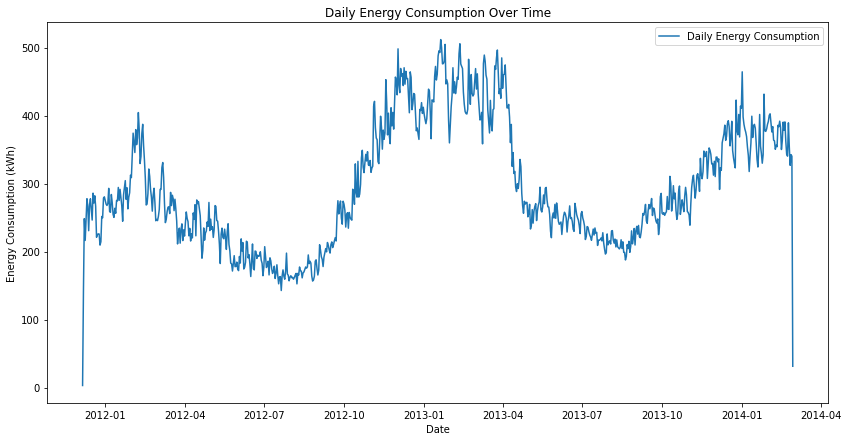

Data resampled to daily frequency.
Performing basic statistical analysis...
       KWH/hh (per half hour)
count           999971.000000
mean                 0.239580
std                  0.387533
min                  0.000000
25%                  0.060000
50%                  0.129000
75%                  0.255000
max                  6.528000
Milestone achieved: loaded Dataset.
Saved preprocessed dataset for Random Forest Model
ADF Statistic: -1.7853864383011775
p-value: 0.3877406762455841
Critical Values:
	1%: -3.438686413400388
	5%: -2.8652194721349424
	10%: -2.5687293001910008


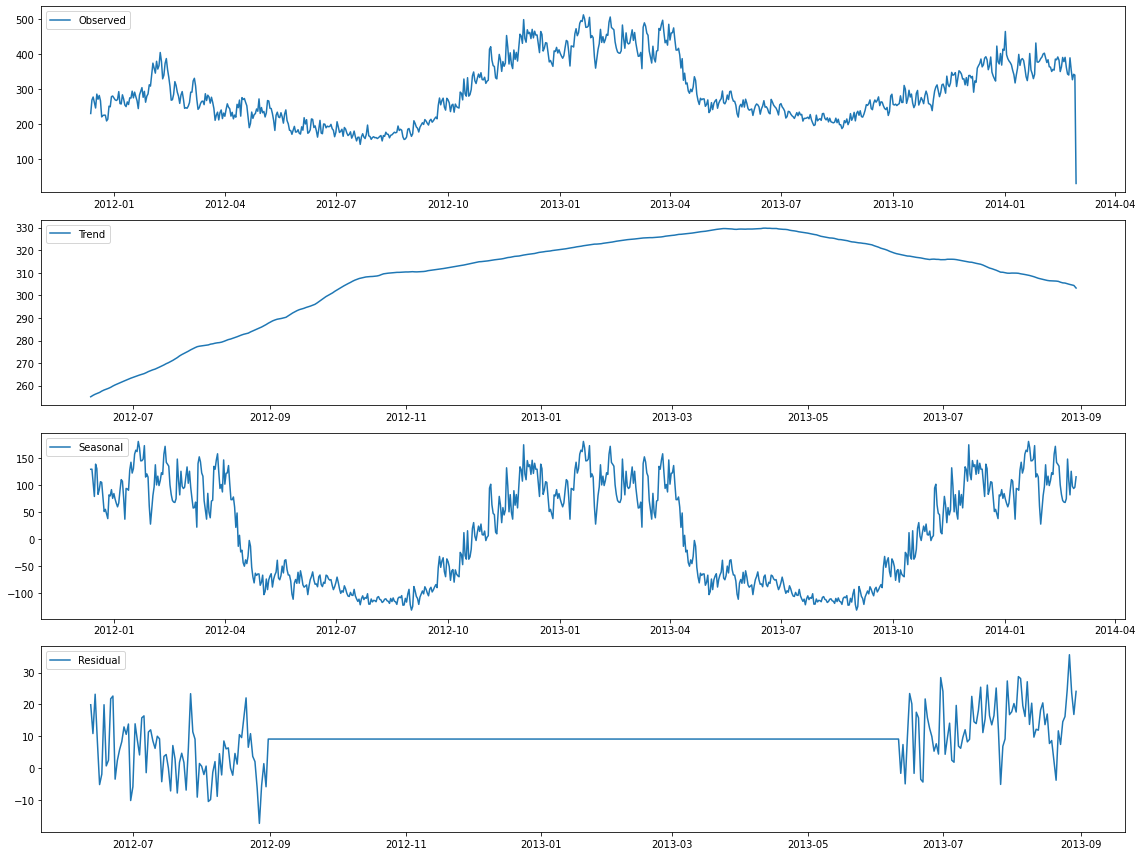

ADF Statistic: -4.642837027710595
p-value: 0.000107616111050603
Critical Values:
	1%: -3.438697054464251
	5%: -2.8652241623148678
	10%: -2.5687317987167284
Saved preprocessed dataset for SARIMA Model
Saved preprocessed dataset for LSTM Model
Milestone Achieved: Preprocessing Completed
Epoch 1/10


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.1135
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0063
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0047
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0042
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0048
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0040
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0046
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0039
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0042
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0046
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

--- Evaluation Metrics ---
Random Forest - MSE: 65.36476153114111, MAE: 5.816476950918275
SARIMA - MSE: 30636.34974926119, MAE: 172.84471936796862
LSTM - MSE: 907.2596650241657, MAE: 21.328933893121942


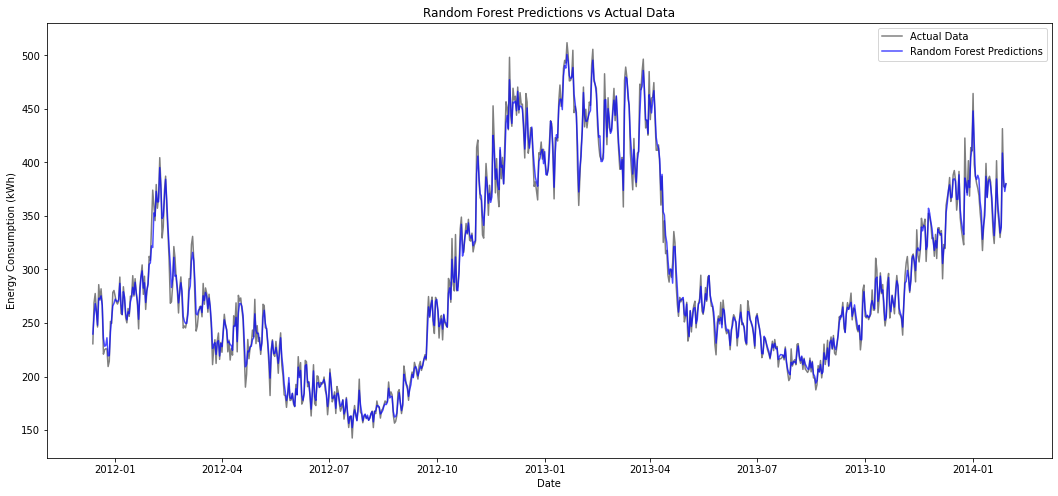

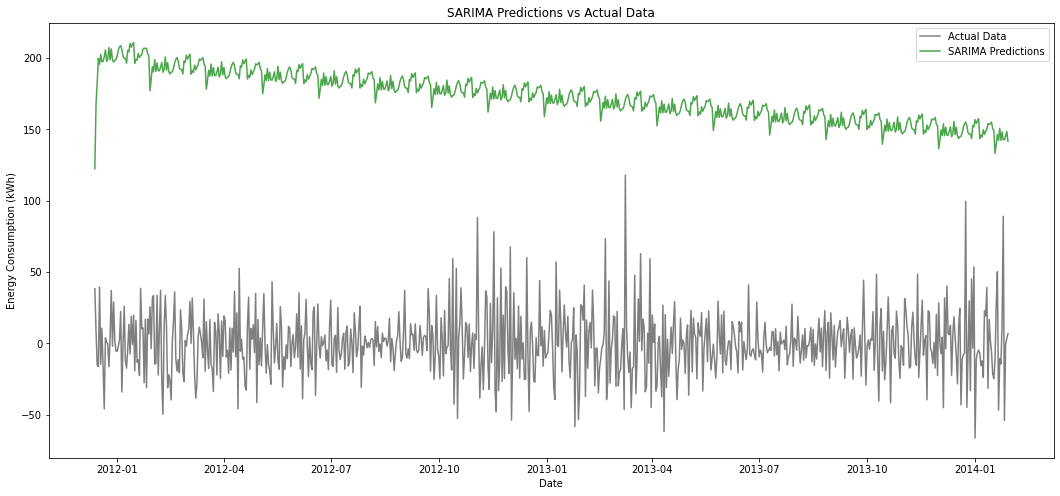

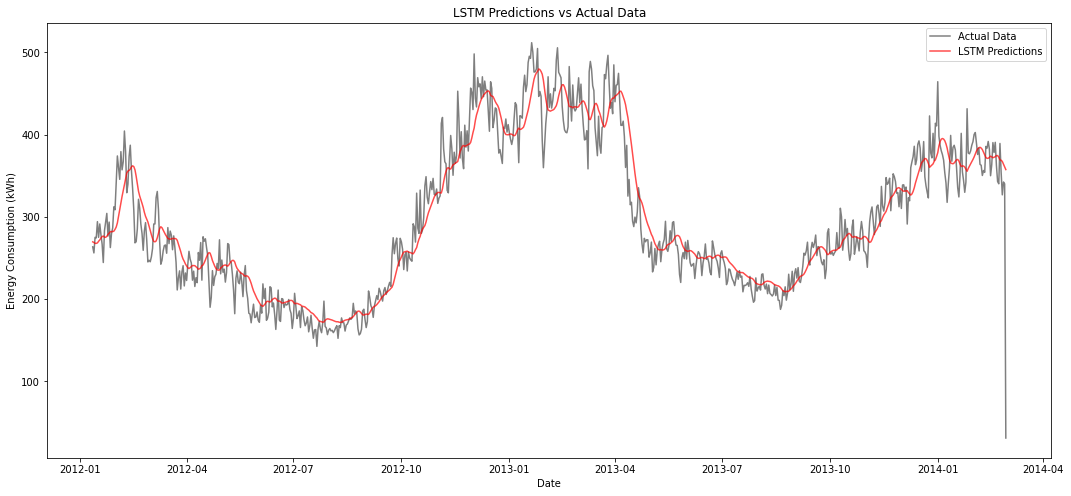

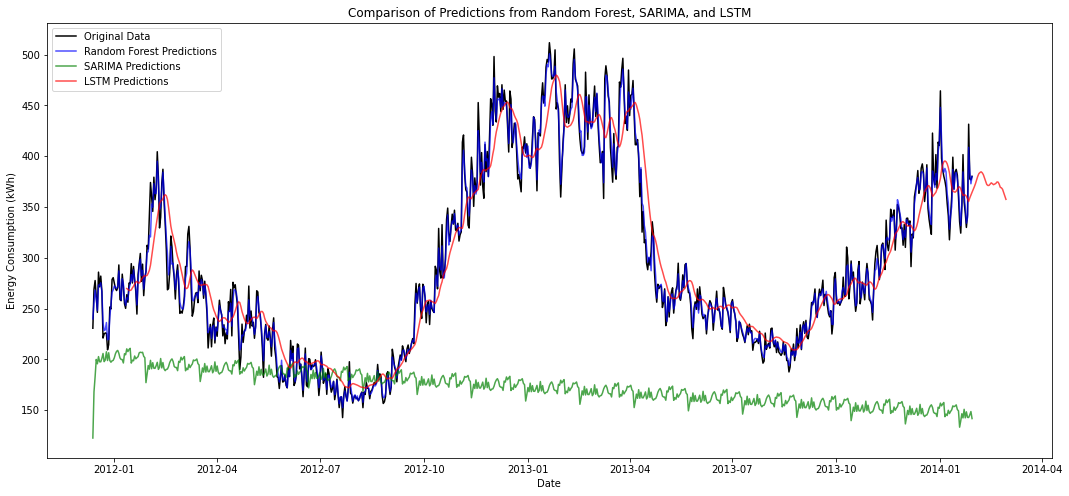

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Define the Random Forest Model
class RandomForestModel:
    def __init__(self):
        self.model = RandomForestRegressor()
        
    def fit(self, X, y):
        self.model.fit(X, y)
        
    def predict(self, X):
        return self.model.predict(X)

# Define the SARIMA Model
class SARIMAXModel:
    def __init__(self, data):
        self.data = data
        self.model = None
        
    def fit(self):
        self.model = SARIMAX(self.data['KWH/hh (per half hour)'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 48))
        self.fit = self.model.fit(disp=False)
        
    def predict(self):
        forecast = self.fit.forecast(steps=len(self.data))
        conf_int = self.fit.get_forecast(steps=len(self.data)).conf_int()
        return forecast, conf_int

# Define the LSTM Model
class LSTMModel:
    def __init__(self, input_shape):
        self.model = self.build_model(input_shape)
        
    def build_model(self, input_shape):
        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
        model.add(LSTM(50))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model
        
    def fit(self, X, y, epochs=50, batch_size=32):
        self.model.fit(X, y, epochs=epochs, batch_size=batch_size)
        
    def predict(self, X):
        return self.model.predict(X)

# Function for project planning
def project_planning():
    print("Defining project scope and objectives...")
    timeline = {
        "Project Planning": "02-06-2024 to 13-06-2024",
        "Preprocessing Approaches": "14-06-2024 to 20-06-2024",
        "Model Development": "21-06-2024 to 01-07-2024",
        "Model Training and Evaluation": "02-07-2024 to 14-07-2024",
        "Comparison and Analysis": "15-07-2024 to 22-07-2024",
        "Documentation and Reporting": "23-07-2024 to 04-08-2024",
        "Presentation and Review": "04-08-2024 to 15-08-2024"
    }
    print("Project timeline created:", timeline)

    print("Loading dataset...")
    dataset = pd.read_csv('LCL-June2015v2_0.csv')

    # Convert 'DateTime' to datetime format
    dataset['DateTime'] = pd.to_datetime(dataset['DateTime'], errors='coerce')
    
    # Trim whitespace from column names
    dataset.columns = dataset.columns.str.strip()

    # Convert 'KWH/hh (per half hour)' to numeric
    dataset['KWH/hh (per half hour)'] = pd.to_numeric(dataset['KWH/hh (per half hour)'], errors='coerce')

    # Set 'DateTime' as the index
    dataset.set_index('DateTime', inplace=True)

    # Resample data to daily frequency, summing the KWH/hh values
    daily_data = dataset.resample('D').sum()
    
    print("Dataset loaded. Preview:")
    print(dataset.head(10))

    print("Column names in the dataset:")
    print(dataset.columns)
    
    # Plot the daily energy consumption
    plt.figure(figsize=(14, 7))
    plt.plot(daily_data.index, daily_data['KWH/hh (per half hour)'], label='Daily Energy Consumption')
    plt.title('Daily Energy Consumption Over Time')
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption (kWh)')
    plt.legend()
    plt.show()
    print("Data resampled to daily frequency.")
    print("Performing basic statistical analysis...")
    print(dataset.describe())
    print("Milestone achieved: loaded Dataset.")

    return daily_data

# Function for preprocessing approaches
def preprocessing_approaches(daily_data):
    
    # Preprocessing for Random Forest
    # Create lag features
    daily_data['Lag_1'] = daily_data['KWH/hh (per half hour)'].shift(1)
    daily_data['Lag_7'] = daily_data['KWH/hh (per half hour)'].shift(7)

    # Create rolling mean feature
    daily_data['Rolling_Mean_7'] = daily_data['KWH/hh (per half hour)'].rolling(window=7).mean()

    # Create time-based features
    daily_data['Day_of_Week'] = daily_data.index.dayofweek
    daily_data['Month'] = daily_data.index.month
    
    # Drop missing values (due to lagging)
    daily_data.dropna(inplace=True)

    # Features and target for Random Forest
    X_rf = daily_data[['Lag_1', 'Lag_7', 'Rolling_Mean_7', 'Day_of_Week', 'Month']]
    y_rf = daily_data['KWH/hh (per half hour)']

    # Ensure X_rf and y_rf have the same length
    X_rf = X_rf.loc[y_rf.index]

    # Saving Random Forest preprocessed data
    X_rf.to_csv('X_rf_preprocessed.csv', index=True)
    y_rf.to_csv('y_rf_preprocessed.csv', index=True)

    print('Saved preprocessed dataset for Random Forest Model')

    # Preprocessing for SARIMA
    
    # Check stationarity using ADF test
    def check_stationarity(timeseries):
        result = adfuller(timeseries)
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'\t{key}: {value}')
    
    check_stationarity(daily_data['KWH/hh (per half hour)'])

    # Seasonal Decomposition to identify trend, seasonality, and residuals
    decomposition = seasonal_decompose(daily_data['KWH/hh (per half hour)'].dropna(), model='additive', period=365)

    plt.figure(figsize=(16, 12))    
    plt.subplot(411)
    plt.plot(decomposition.observed, label='Observed')
    plt.legend(loc='upper left')

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='upper left')

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend(loc='upper left')

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    # Differencing to remove non-stationarity (if needed)
    daily_data['Diff'] = daily_data['KWH/hh (per half hour)'].diff().dropna()
    
    # Check stationarity again after differencing
    check_stationarity(daily_data['Diff'].dropna())

    # Use the differenced data as input for SARIMA
    y_sarima = daily_data['Diff'].dropna()

    # Saving SARIMA preprocessed data
    y_sarima.to_csv('y_sarima_preprocessed.csv', index=True)

    print('Saved preprocessed dataset for SARIMA Model')

    # Preprocessing for LSTM

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(daily_data['KWH/hh (per half hour)'].values.reshape(-1, 1))

    # Create sequences
    sequence_length = 30  
    X_lstm = []
    y_lstm = []

    for i in range(sequence_length, len(scaled_data)):
        X_lstm.append(scaled_data[i-sequence_length:i, 0])
        y_lstm.append(scaled_data[i, 0])

    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

    # Reshape data for LSTM model (samples, time steps, features)
    X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

    # Saving LSTM preprocessed data
    np.save('X_lstm_preprocessed.npy', X_lstm)
    np.save('y_lstm_preprocessed.npy', y_lstm)

    print('Saved preprocessed dataset for LSTM Model')

    print('Milestone Achieved: Preprocessing Completed')
    
    return X_rf, y_rf, y_sarima, X_lstm, y_lstm

# Function to train and evaluate all models
def train_and_evaluate_models(X_rf, y_rf, y_sarima, X_lstm, y_lstm, daily_data):
    
    # Train Random Forest
    rf_model = RandomForestModel()
    rf_model.fit(X_rf, y_rf)
    rf_predictions = rf_model.predict(X_rf)

    # Train SARIMA
    sarima_model = SARIMAXModel(daily_data)
    sarima_model.fit()
    sarima_predictions, _ = sarima_model.predict()

    # Ensure sarima_predictions length matches y_sarima
    sarima_predictions = sarima_predictions[:len(y_sarima)]

    # Train LSTM
    lstm_model = LSTMModel((X_lstm.shape[1], X_lstm.shape[2]))
    lstm_model.fit(X_lstm, y_lstm, epochs=10, batch_size=32)  # Reduced epochs for faster training
    lstm_predictions = lstm_model.predict(X_lstm)

    # Rescale LSTM predictions back to original scale
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(daily_data['KWH/hh (per half hour)'].values.reshape(-1, 1))
    lstm_predictions = scaler.inverse_transform(lstm_predictions)

    # Ensure consistent lengths for comparison
    min_length = min(len(rf_predictions), len(sarima_predictions), len(lstm_predictions))

    rf_predictions = rf_predictions[:min_length]
    sarima_predictions = sarima_predictions[:min_length]
    lstm_predictions = lstm_predictions[:min_length]

    # Align the target variables to the predictions
    y_rf = y_rf.iloc[:min_length]
    y_sarima = y_sarima.iloc[:min_length]
    y_lstm = y_lstm[:min_length]

    # Evaluation
    print("\n--- Evaluation Metrics ---")

    # Random Forest Metrics
    rf_mse = mean_squared_error(y_rf, rf_predictions)
    rf_mae = mean_absolute_error(y_rf, rf_predictions)
    print(f"Random Forest - MSE: {rf_mse}, MAE: {rf_mae}")

    # SARIMA Metrics
    sarima_mse = mean_squared_error(y_sarima, sarima_predictions)
    sarima_mae = mean_absolute_error(y_sarima, sarima_predictions)
    print(f"SARIMA - MSE: {sarima_mse}, MAE: {sarima_mae}")

    # LSTM Metrics
    y_lstm_rescaled = scaler.inverse_transform(y_lstm.reshape(-1, 1))
    lstm_mse = mean_squared_error(y_lstm_rescaled, lstm_predictions)
    lstm_mae = mean_absolute_error(y_lstm_rescaled, lstm_predictions)
    print(f"LSTM - MSE: {lstm_mse}, MAE: {lstm_mae}")

    # Random Forest Predictions
    plt.figure(figsize=(18, 8))
    plt.plot(daily_data.index[:min_length], y_rf, label='Actual Data', color='black', alpha=0.5)
    plt.plot(daily_data.index[:min_length], rf_predictions, label='Random Forest Predictions', color='blue', alpha=0.7)
    plt.title('Random Forest Predictions vs Actual Data')
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption (kWh)')
    plt.legend()
    plt.show()

    # SARIMA Predictions
    plt.figure(figsize=(18, 8))
    plt.plot(daily_data.index[:min_length], y_sarima, label='Actual Data', color='black', alpha=0.5)
    plt.plot(daily_data.index[:min_length], sarima_predictions, label='SARIMA Predictions', color='green', alpha=0.7)
    plt.title('SARIMA Predictions vs Actual Data')
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption (kWh)')
    plt.legend()
    plt.show()

    # LSTM Predictions
    plt.figure(figsize=(18, 8))
    plt.plot(daily_data.index[30:30+min_length], y_lstm_rescaled[:min_length], label='Actual Data', color='black', alpha=0.5)
    plt.plot(daily_data.index[30:30+min_length], lstm_predictions[:min_length], label='LSTM Predictions', color='red', alpha=0.7)
    plt.title('LSTM Predictions vs Actual Data')
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption (kWh)')
    plt.legend()
    plt.show()

    # Plot results
    plt.figure(figsize=(18, 8))
    
    # Original data
    plt.plot(daily_data.index[:min_length], daily_data['KWH/hh (per half hour)'].iloc[:min_length], label='Original Data', color='black')

    # Random Forest Predictions
    plt.plot(daily_data.index[:min_length], rf_predictions, label='Random Forest Predictions', color='blue', alpha=0.7)

    # SARIMA Predictions
    plt.plot(daily_data.index[:min_length], sarima_predictions, label='SARIMA Predictions', color='green', alpha=0.7)

    # LSTM Predictions
    plt.plot(daily_data.index[30:30+min_length], lstm_predictions, label='LSTM Predictions', color='red', alpha=0.7)
    
    plt.title('Comparison of Predictions from Random Forest, SARIMA, and LSTM')
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption (kWh)')
    plt.legend()
    plt.show()

# Main execution
if __name__ == "__main__":
    daily_data = project_planning()
    X_rf, y_rf, y_sarima, X_lstm, y_lstm = preprocessing_approaches(daily_data)
    train_and_evaluate_models(X_rf, y_rf, y_sarima, X_lstm, y_lstm, daily_data)
